In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from lfw_dataset import fetch_lfw_dataset

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
from lfw_dataset import fetch_lfw_dataset
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

images not found, donwloading...
extracting...
done
/content
attributes not found, downloading...
done


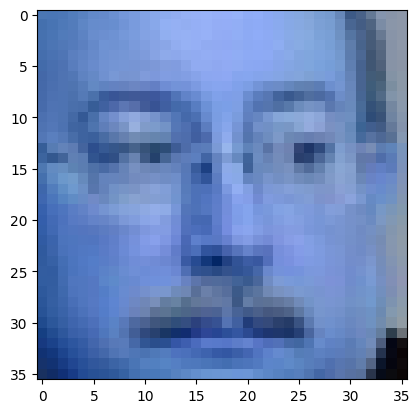

In [5]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [7]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=1,activation='elu'))

#final layer
generator.add(L.Conv2DTranspose(3, kernel_size=1, activation='sigmoid'))

In [8]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

In [9]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))

#<build discriminator body>
discriminator.add(L.Conv2D(32, kernel_size=3, activation='elu'))
discriminator.add(L.Conv2D(32, kernel_size=3, activation='elu'))
discriminator.add(L.Conv2D(64, kernel_size=(5, 5), activation='elu'))
discriminator.add(L.Conv2D(64, kernel_size=(5, 5), activation='elu'))
discriminator.add(L.MaxPooling2D(pool_size=(2, 2)))


discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

In [10]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

In [11]:
disc_optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
gen_optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.5)

In [12]:
from tqdm import tnrange

In [13]:
for epoch in tnrange(1000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)

    with tf.GradientTape() as tape:
        generated_data = generator(noise)
        logp_gen = discriminator(generated_data)
        g_loss = -tf.reduce_mean(logp_gen[:, 1])

        # Optimize
        gen_gradients = tape.gradient(g_loss, generator.trainable_variables)
        gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))


    with tf.GradientTape() as tape:
        generated_data = generator(noise)
        logp_real = discriminator(real_data)
        logp_gen = discriminator(generated_data)
        d_loss = -tf.reduce_mean(logp_real[:, 1] + logp_gen[:, 0])
        d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

    # Optimize
    disc_gradients = tape.gradient(d_loss, discriminator.trainable_weights)
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_weights))



generator.save("generator_model.h5")
discriminator.save("discriminator_model.h5")

<ipython-input-13-b6dfee1fad9c>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(1000):


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


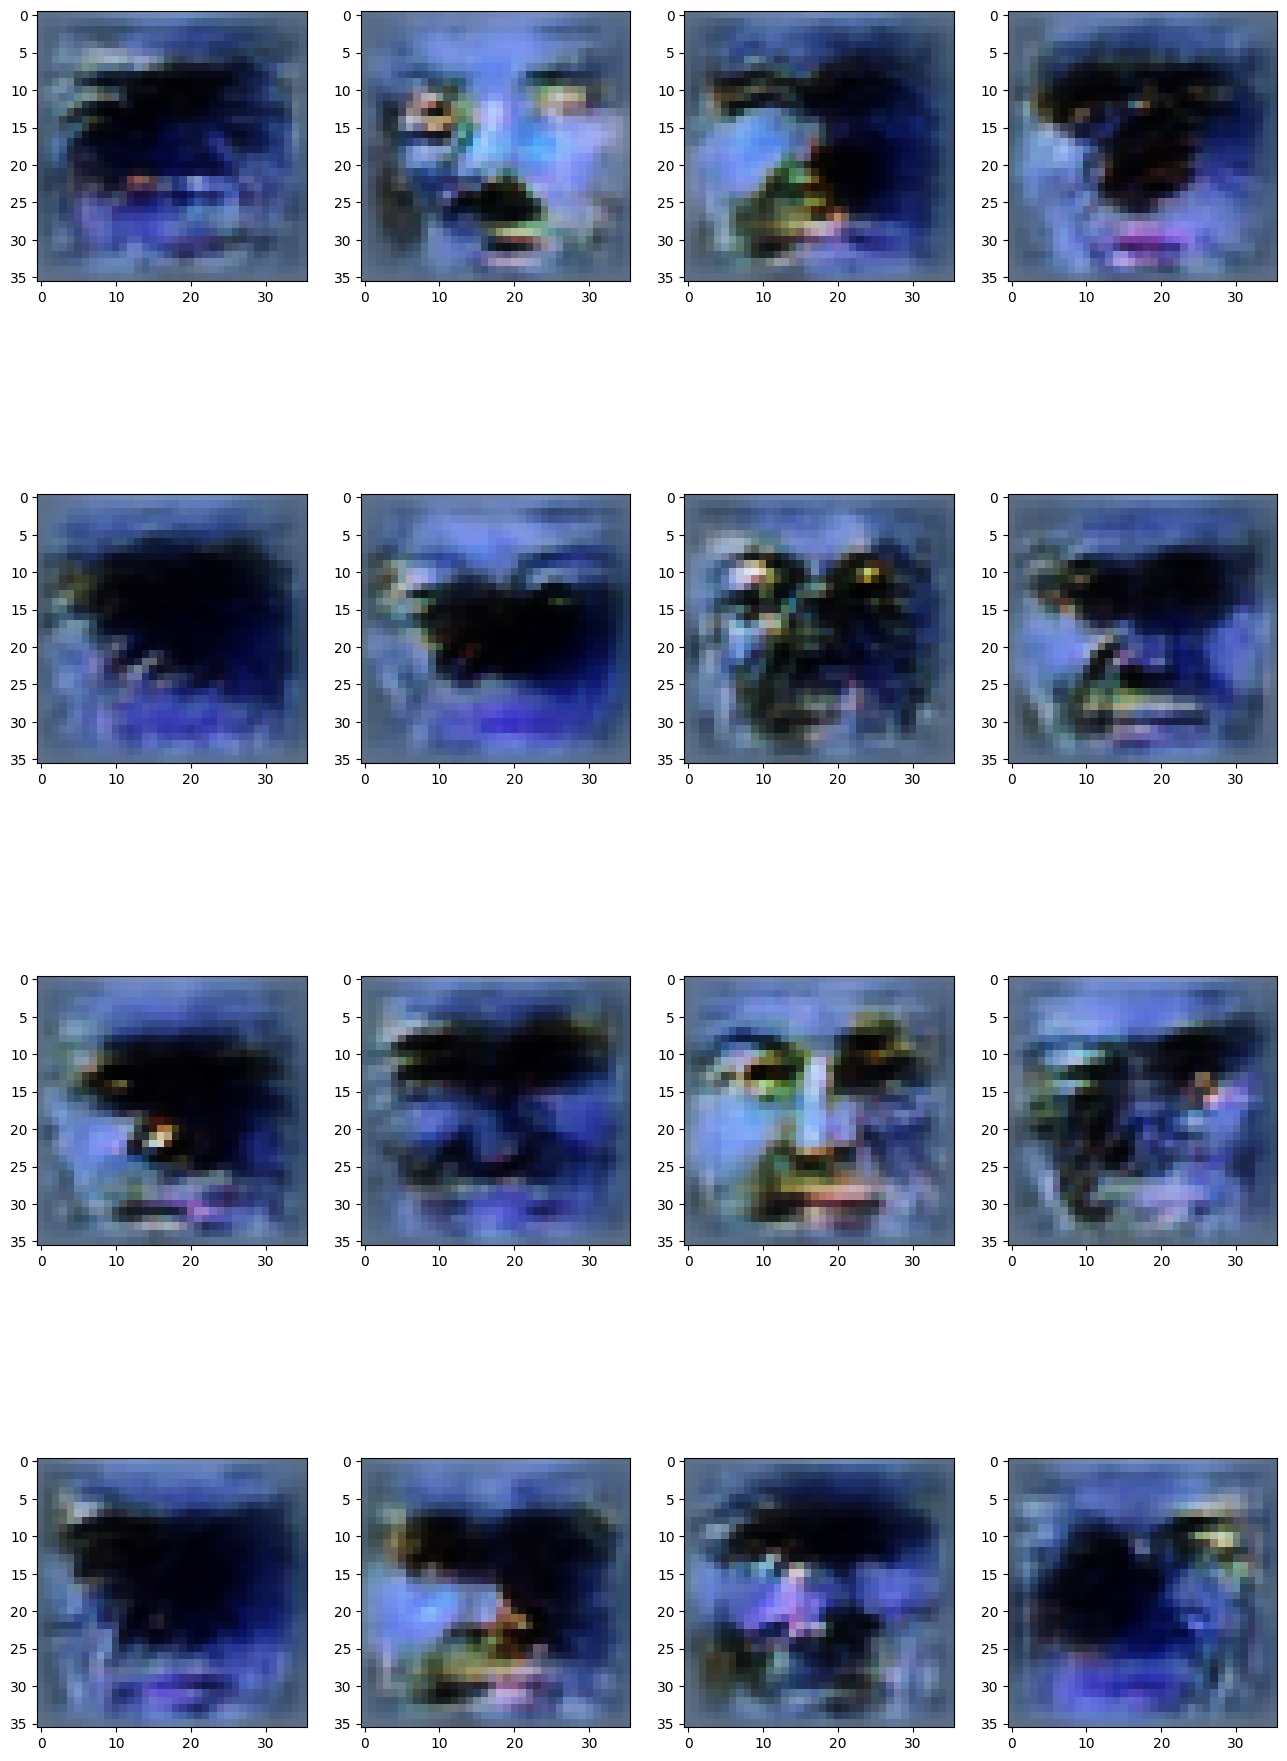

In [14]:
plt.figure(figsize=[16,24])
sample_images(4,4)